# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Make accurate salary preditctions for new job postings that are based on known salaries so the company is able to recruit and retain top talent while controlling payroll expenses.

In [1]:
# Import libraries
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# My info 
__author__ = "Dominick DiTucci"
__email__ = "djditucci@gmail.com "

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
# Load the data into a Pandas dataframe

test_features = '/Users/DJ/Salary-Prediction-Portfolio/data/test_features.csv'
train_features = '/Users/DJ/Salary-Prediction-Portfolio/data/train_features.csv'
train_salaries = '/Users/DJ/Salary-Prediction-Portfolio/data/train_salaries.csv'

test_featuresDF = pd.read_csv(test_features)
train_featuresDF = pd.read_csv(train_features)
train_salariesDF = pd.read_csv(train_salaries)

In [3]:
# View all columns headers
print(test_featuresDF.columns)
print(train_featuresDF.columns)
print(train_salariesDF.columns)

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis'],
      dtype='object')
Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis'],
      dtype='object')
Index(['jobId', 'salary'], dtype='object')


### ---- 3 Clean the data ----

In [4]:
# Look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it

# Check for missing data in test_featuresDF

missing_test_featuresDF = test_featuresDF.isnull()

for column in missing_test_featuresDF.columns.values.tolist():
    print(column)
    print(missing_test_featuresDF[column].value_counts())
    print("")

jobId
False    1000000
Name: jobId, dtype: int64

companyId
False    1000000
Name: companyId, dtype: int64

jobType
False    1000000
Name: jobType, dtype: int64

degree
False    1000000
Name: degree, dtype: int64

major
False    1000000
Name: major, dtype: int64

industry
False    1000000
Name: industry, dtype: int64

yearsExperience
False    1000000
Name: yearsExperience, dtype: int64

milesFromMetropolis
False    1000000
Name: milesFromMetropolis, dtype: int64



In [5]:
# Check top 5 rows of test_featuresDF
print("The first 5 rows of test_featuresDF:")
test_featuresDF.head()

The first 5 rows of test_featuresDF:


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [6]:
# Check shape of test_featuresDF
print('The shape of test_featuresDF is: ', test_featuresDF.shape)

The shape of test_featuresDF is:  (1000000, 8)


In [7]:
# Check for missing data in train_featuresDF

missing_train_featuresDF = train_featuresDF.isnull()

for column in missing_train_featuresDF.columns.values.tolist():
    print(column)
    print(missing_train_featuresDF[column].value_counts())
    print("")

jobId
False    1000000
Name: jobId, dtype: int64

companyId
False    1000000
Name: companyId, dtype: int64

jobType
False    1000000
Name: jobType, dtype: int64

degree
False    1000000
Name: degree, dtype: int64

major
False    1000000
Name: major, dtype: int64

industry
False    1000000
Name: industry, dtype: int64

yearsExperience
False    1000000
Name: yearsExperience, dtype: int64

milesFromMetropolis
False    1000000
Name: milesFromMetropolis, dtype: int64



In [8]:
# Check top 5 rows of train_featuresDF
print("The first 5 rows of train_featuresDF:")
train_featuresDF.head()


The first 5 rows of train_featuresDF:


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [9]:
# Check shape of train_featuresDF
print('The shape of train_featuresDF is: ', train_featuresDF.shape)

The shape of train_featuresDF is:  (1000000, 8)


In [10]:
# Check for missing data in train_salariesDF

missing_train_salariesDF = train_salariesDF.isnull()

for column in missing_train_salariesDF.columns.values.tolist():
    print(column)
    print(missing_train_salariesDF[column].value_counts())
    print("")

jobId
False    1000000
Name: jobId, dtype: int64

salary
False    1000000
Name: salary, dtype: int64



In [11]:
# Check shape of train_salariesDF before deleting values
print('The shape of train_salariesDF is:', train_salariesDF.shape)

The shape of train_salariesDF is: (1000000, 2)


In [12]:
# Check top 5 rows of train_salariesDF
print("The first 5 rows of train_salariesDF:")
train_salariesDF.head()

The first 5 rows of train_salariesDF:


,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [13]:
# train_salariesDF and train__featuresDF have overlapping data, so they can be merged

train_data_merged = pd.merge(train_salariesDF, train_featuresDF, on = 'jobId')

# Check shape of merged data
print("The shape of train_data_merged is:",  train_data_merged.shape)

The shape of train_data_merged is: (1000000, 9)


In [14]:
# Check for invalid salaries, show with jobid

zero_salary = train_salariesDF['salary']<=0
invalid_salary = train_salariesDF[zero_salary]

invalid_salary


,jobId,salary
30559,JOB1362684438246,0
495984,JOB1362684903671,0
652076,JOB1362685059763,0
816129,JOB1362685223816,0
828156,JOB1362685235843,0


In [15]:
# Remove invalid salaries since there are only 5/1,000,000

train_data_merged = train_data_merged.drop(invalid_salary.index.tolist())

print(train_data_merged)

                   jobId  salary companyId         jobType       degree  \
0       JOB1362684407687     130    COMP37             CFO      MASTERS   
1       JOB1362684407688     101    COMP19             CEO  HIGH_SCHOOL   
2       JOB1362684407689     137    COMP52  VICE_PRESIDENT     DOCTORAL   
3       JOB1362684407690     142    COMP38         MANAGER     DOCTORAL   
4       JOB1362684407691     163     COMP7  VICE_PRESIDENT    BACHELORS   
5       JOB1362684407692     113    COMP15         MANAGER     DOCTORAL   
6       JOB1362684407693     178    COMP15             CFO         NONE   
7       JOB1362684407694      73    COMP24          JUNIOR    BACHELORS   
8       JOB1362684407695      31    COMP20         JANITOR  HIGH_SCHOOL   
9       JOB1362684407696     104    COMP41  VICE_PRESIDENT    BACHELORS   
10      JOB1362684407697     102    COMP56         JANITOR  HIGH_SCHOOL   
11      JOB1362684407698     144     COMP7             CEO      MASTERS   
12      JOB1362684407699 

In [16]:
# Reset index, because we droped 5 rows
train_data_merged.reset_index(drop=True, inplace=True)

In [17]:
# Check last 5 rows
train_data_merged.tail()

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
999990,JOB1362685407682,88,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94
999991,JOB1362685407683,160,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35
999992,JOB1362685407684,64,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81
999993,JOB1362685407685,149,COMP3,CFO,MASTERS,NONE,HEALTH,6,5
999994,JOB1362685407686,88,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11


In [18]:
# Check data types
train_data_merged.dtypes

jobId                  object
salary                  int64
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
dtype: object

### ---- 4 Explore the data (EDA) ----

In [19]:
# summarize each feature variable
# summarize the target variable
# look for correlation between each feature and the target
# look for correlation between features

In [28]:
# Summary statistics for int/floats
train_data_merged.describe()

,salary,yearsExperience,milesFromMetropolis
count,999995.000000,999995.000000,999995.000000
mean,116.062398,11.992407,49.529381
std,38.717163,7.212390,28.877721
min,17.000000,0.000000,0.000000
25%,88.000000,6.000000,25.000000
50%,114.000000,12.000000,50.000000
75%,141.000000,18.000000,75.000000
max,301.000000,24.000000,99.000000


In [29]:
# Summary for categorical data
train_data_merged.describe(include=object)

,jobId,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995,999995
unique,999995,63,8,5,9,7
top,JOB1362685144318,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236975,532353,143205


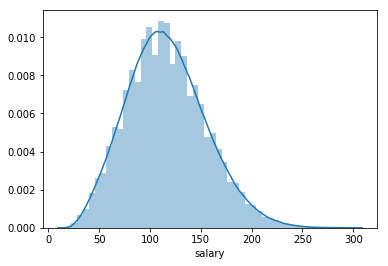

In [30]:
# View distribution of salaries
sns.distplot(train_data_merged['salary'])


In [31]:
# Distribution appears normal, check skewness and kurtosis
print("Salary skewness:", train_data_merged['salary'].skew())
print("Salary kurtosis:", train_data_merged['salary'].skew())

if train_data_merged['salary'].skew() <= 0.5:
    print("Salary distribution is approximately symmetric")
elif train_data_merged['salary'].skew() > 0.5:
        print("Salary distribution is skewed")

Salary skewness: 0.34652727907668734
Salary kurtosis: 0.34652727907668734
Salary distribution is approximately symmetric


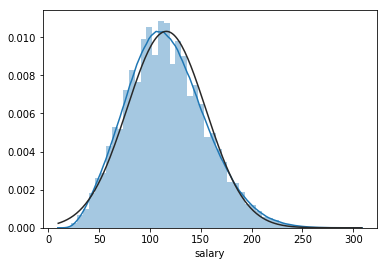

In [32]:
# Visually verify normal distribution
sns.distplot(train_data_merged['salary'], fit=norm)

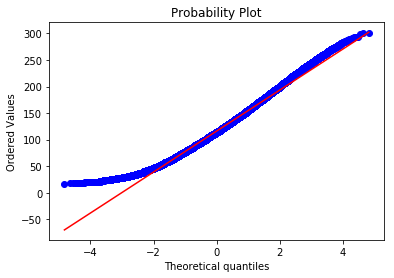

In [33]:
res = stats.probplot(train_data_merged['salary'], plot=plt)

In [34]:
# Check correlation between salary, experience, and distance from metropolis
train_data_merged.corr()

# weak correlation...?

,salary,yearsExperience,milesFromMetropolis
salary,1.000000,0.375013,-0.297686
yearsExperience,0.375013,1.000000,0.000672
milesFromMetropolis,-0.297686,0.000672,1.000000


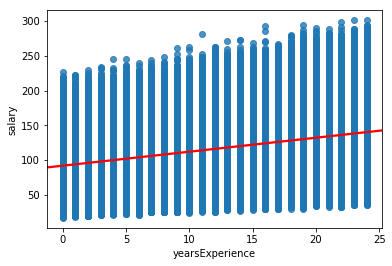

In [35]:
# Years experience as potential predictor of salary
sns.regplot(x = 'yearsExperience', y = 'salary', data = train_data_merged, line_kws = {'color': 'red'})
#moderate positive correlation

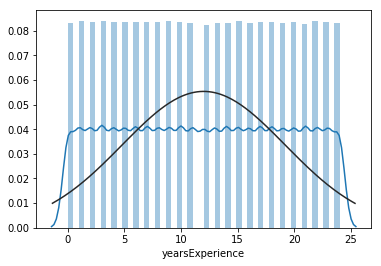

In [36]:
# Check for normal distribution of years experience
sns.distplot(train_data_merged['yearsExperience'], fit=norm)

# Years of experience distribution is relatively uniform

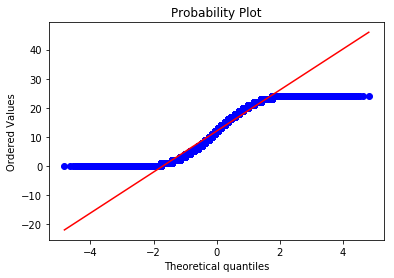

In [37]:
res = stats.probplot(train_data_merged['yearsExperience'], plot=plt)

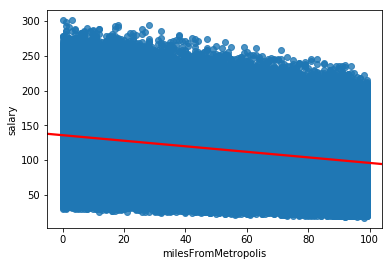

In [38]:
# Miles from metropolis as potential predictor of salary
sns.regplot(x = 'milesFromMetropolis', y = 'salary', data = train_data_merged, line_kws = {'color': 'red'})
# weak negative correlation

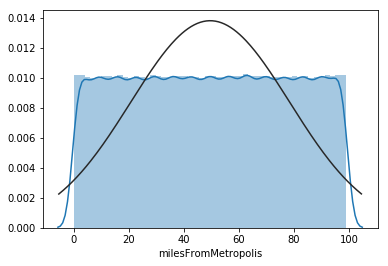

In [39]:
# Check for normal distribution of mile from metropolis
sns.distplot(train_data_merged['milesFromMetropolis'], fit=norm)

# Miles from metropolis distribution is relatively uniform

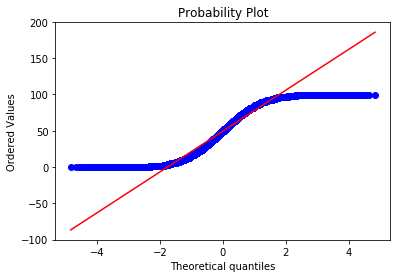

In [40]:
res = stats.probplot(train_data_merged['milesFromMetropolis'], plot=plt)

In [57]:
# Group companies by company ID (come back to this)
# companyId_grouped = train_data_merged.groupby(['companyId'])


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
 <a list of 63 Text xticklabel objects>)

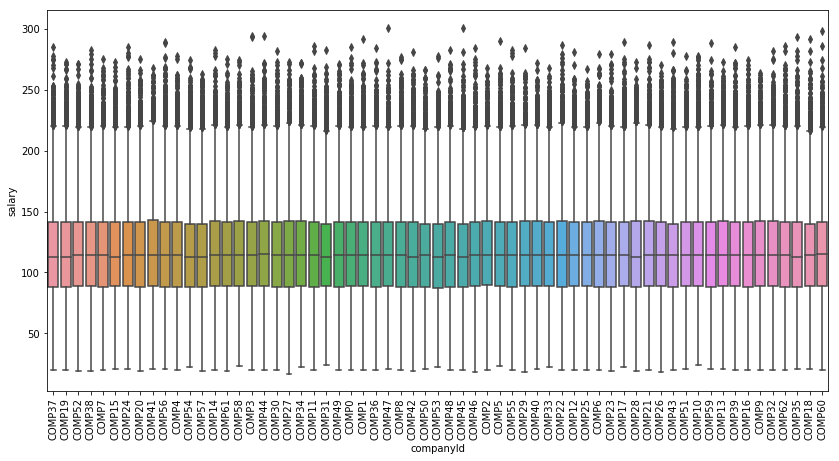

In [52]:
# View relationship between salary and company ID
var = 'companyId'
data = pd.concat([train_data_merged['salary'], train_data_merged[var]], axis = 1)
f, ax = plt.subplots(figsize=(14, 7))
fig = sns.boxplot(x=var, y='salary', data=data)
plt.xticks(rotation=90)

#Removed for size issue
#companySalary = sns.boxplot(x= 'companyId', y="salary", data=train_data_merged)
#plt.companySalary.set_xticklabels(companySalary.get_xticklabels(), rotation=30).figur(figsize=(16,6))


In [ ]:
# View relationship between salary and job type
jobSalary = sns.boxplot(x= 'jobType', y="salary", data=train_data_merged)
jobSalary.set_xticklabels(jobSalary.get_xticklabels(), rotation=45)

In [ ]:
# View relationship between salary and degree
degreeSalary = sns.boxplot(x= 'degree', y="salary", data=train_data_merged)
degreeSalary.set_xticklabels(degreeSalary.get_xticklabels(), rotation=45)

# Having a college degree vs no college degree seems to have a correlation with salary

In [ ]:
# View relationship between salary and major
collMajorSalary = sns.boxplot(x='major', y='salary', data=train_data_merged)
collMajorSalary.set_xticklabels(collMajorSalary.get_xticklabels(), rotation=45)

# Having no major correlated with lower salary than having a major

In [ ]:
# View relationship between salary and industry
industrySalary = sns.boxplot(x='industry', y='salary', data=train_data_merged)
industrySalary.set_xticklabels(industrySalary.get_xticklabels(), rotation=45)

# Education and service industries seem to have lowest salaries, followed by auto in dustry

In [ ]:
# Generate heatmap from correlation matrix
sns.heatmap(train_data_merged.corr(), annot=True)

In [ ]:
cols = ['salary','yearsExperience', 'milesFromMetropolis']

sns.pairplot(train_data_merged[cols])

In [ ]:
# Check for outliers
salary_scaled = StandardScaler().fit_transform(train_data_merged['salary'][:,np.newaxis]);
low_range = salary_scaled[salary_scaled[:,0].argsort()][:10]
high_range= salary_scaled[salary_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

# No single datapoint too far out of range

### ---- 5 Establish a baseline ----

In [ ]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [ ]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [ ]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data